In [1]:
import numpy as np
import pandas as pd 
import os
print(os.listdir("../input/"))

['precipitation_data']


In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision import models
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import SequentialSampler, BatchSampler
from torch._six import int_classes as _int_classes

from fastai import *
from fastai.vision import *

from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import PIL
import scipy

import math
import pdb
import glob
import time
import copy
from pathlib import Path

In [3]:
from tqdm import tqdm, tnrange, tqdm_notebook
from time import sleep

In [4]:
np.random.seed(42)
torch.random.manual_seed(42)

In [5]:
torch.set_default_tensor_type('torch.FloatTensor')

In [6]:
WORK_PATH = Path('kaggle/working')
DATA_PATH = Path('../input/precipitation_data/data/')

In [7]:
f_names = glob.glob('../input/precipitation_data/data/*.gif')

In [8]:
f_names.sort()
train_idx = int(len(f_names)*0.9)
train_f = f_names[:train_idx]
val_f = f_names[train_idx:]

In [9]:
def norm(im):
    x = im
    x = x/255*2 - 1
    return x

In [10]:
def denorm(im):
    x=im
    x = (x + 1)/2*255
    return x 

In [11]:
h = 128
w = 160
bs = 8
bptt = 7
lr = 1e-3
epoch = 60

In [12]:
transforms = tv.transforms.Compose([tv.transforms.Resize((h, w)), tv.transforms.ToTensor(),
                                    tv.transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))])

In [13]:
def denormalize(inp):
    inp = inp.view(-1, 4, h, w).clamp(-1, 1)
    inp = to_np(inp).transpose((0, 2, 3, 1))
    mean = np.array([0.5, 0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = (255*np.clip(inp, 0, 1)).astype(np.uint8)
    return inp

In [14]:
class Image_Dataset(Dataset):
    def __init__(self, f_names, transform=None):
        self.fnames = f_names
        self.transform = transform
    def fetch_single_image(self, i):
        im = PIL.Image.open(f_names[i]).convert('RGBA')
        if self.transform:
            im = self.transform(im)
        return im
    def fetch_multi_image(self,idxs):
        bunch = []
        for i in idxs:
            bunch.append(self.fetch_single_image(i))
        return torch.stack(bunch)
    def __len__(self):
        return len(self.fnames) - 1
    def __getitem__(self, i):
        if type(i) == int:
            X = self.fetch_single_image(i)
            y = self.fetch_single_image(i + 1)
        elif type(i) == list:
            i = np.array(i)
            X = self.fetch_multi_image(i)
            y = self.fetch_multi_image(i + 1)
        return (X, y)

In [15]:
train_ds = Image_Dataset(train_f, transforms)
val_ds = Image_Dataset(val_f, transforms)

In [16]:
len(train_ds), len(val_ds)

(2144, 238)

In [17]:
def gen_seq(length, bptt):
    sums = 0
    seqs = []
    lengths = np.round(np.random.normal(bptt, 1, 1000)).astype(np.int64)
    while sums < length:
        idx = np.random.randint(0, len(lengths))
        seq = lengths[idx]
        if sums + seq > length:
            seq = length - sums
        seqs.append(seq)
        sums += seq
    return seqs

In [18]:
class SequenceBatchSampler(Sampler):

    def __init__(self, sampler, batch_size, drop_last=True, val=False):
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of "
                             "torch.utils.data.Sampler, but got sampler={}"
                             .format(sampler))
        if not isinstance(batch_size, _int_classes) or isinstance(batch_size, bool) or \
                batch_size <= 0:
            raise ValueError("batch_size should be a positive integeral value, "
                             "but got batch_size={}".format(batch_size))
        if not isinstance(drop_last, bool):
            raise ValueError("drop_last should be a boolean value, but got "
                             "drop_last={}".format(drop_last))
            
        init_len = len(sampler)
        fac = math.ceil(init_len/batch_size)
        idxs = []
        for f in range(fac):
            idxs_i = []
            for b in range(batch_size):
                idx = f + fac*b
                if idx > init_len - 1: break
                idxs_i.append(idx)
            idxs.append(idxs_i)
            
        if val:
            self.seqs = gen_seq(init_len, bptt)
         
        self.bs = batch_size
        self.sampler = idxs
        self.drop = drop_last
        self.val = val

    def __iter__(self):
        
        if not self.val:
            fac = len(train_ds)/self.bs
            self.seqs = gen_seq(fac, bptt)
        
        batch = []
        seq_idx = 0
        
        for idx in self.sampler:
            if len(idx) < self.bs:
                break
            batch.append(idx)
            if len(batch) == self.seqs[seq_idx]:
                yield batch
                seq_idx += 1
                batch = []
                
        if len(batch) > 0 and not self.drop:
            yield batch

    def __len__(self):
        return len(self.sampler)

In [19]:
train_sampler = SequenceBatchSampler(SequentialSampler(train_ds), bs) # 2,4,8,16,32
val_sampler = SequenceBatchSampler(SequentialSampler(val_ds), 7, val=True) # 2,7,14,17

In [20]:
train_dl = DataLoader(train_ds, batch_sampler=train_sampler, num_workers=0)
val_dl = DataLoader(val_ds, batch_sampler=val_sampler, num_workers=0)

In [21]:
def conv_layer(nin, nout, ks=3, stride=1):
    conv = nn.Conv2d(nin, nout, ks, stride, padding=ks//2, bias=False)
    torch.nn.init.normal_(conv.weight, std=np.sqrt(1/nin))
    return nn.Sequential(
    conv,
    nn.BatchNorm2d(nout),
    nn.SELU(True)
    )

In [22]:
def dense_layer(nin, nout):
    drop = nn.Dropout(p=0.05)
    lin = nn.Linear(nin, nout)
    torch.nn.init.normal_(lin.weight, std=np.sqrt(1/nin))
    return nn.Sequential(
    drop,
    lin,
    nn.BatchNorm1d(nout),
    nn.SELU(True)
    )

In [23]:
def deconv_layer(nin, nout, ks=4, stride=2, padding=1):
    deconv = nn.ConvTranspose2d(nin, nout, ks, stride=stride, padding=padding, bias=False)
    torch.nn.init.normal_(deconv.weight, std=np.sqrt(1/nin))
    return nn.Sequential(
    deconv,
    nn.SELU(True),
    nn.BatchNorm2d(nout)
    )

In [24]:
def up_sample(nin, nout, fac=2, ks=3, stride=1, size=None):
    #up = nn.UpsamplingBilinear2d(scale_factor=fac, size=size)
    if fac == None:
        up = nn.UpsamplingBilinear2d(scale_factor=fac, size=size)
        conv = conv_layer(nin, nout, ks=ks, stride=stride)
    else:
        up = nn.PixelShuffle(fac)
        conv = conv_layer(int(nout/fac), nout, ks=ks, stride=stride)
    #bn = nn.BatchNorm2d(nout)
    return nn.Sequential(
        up, 
        conv
    )

In [25]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        drop = nn.Dropout2d(p=0.1)
        self.conv_layers = [conv_layer(4, 32, ks=3, stride=2)] # (32, 64, 80)
        self.conv_layers += [conv_layer(32, 64, ks=3, stride=2)] # (64, 32, 40)
        self.conv_layers += [drop]
        self.conv_layers += [conv_layer(64, 128, ks=3, stride=2)] # (128, 16, 20)
        self.conv_layers += [conv_layer(128, 256, ks=3, stride=2)] # (256, 8, 10)
        #self.conv_layers += [drop]
        self.conv_layers += [conv_layer(256, 512, ks=3, stride=2)] # (512, 4, 5)
        self.pool = nn.AdaptiveMaxPool2d((2, 2), return_indices=True) # (512, 2, 2)
        self.final = [Flatten()] # (1, 2048)
        self.final += [dense_layer(2048, 2048)] # (1, 2048)
        self.conv_layers = nn.Sequential(*self.conv_layers)
        self.final = nn.Sequential(*self.final)
    def forward(self, x):
        s, b, c, h, w = x.shape
        x = x.view(-1, c, h, w)
        x = self.conv_layers(x)
        x, ind = self.pool(x)
        return self.final(x).view(s, b, -1), ind

In [26]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        drop = nn.Dropout2d(p=0.05)
        self.dense = dense_layer(2048, 2048) # (1, 2048), (512, 2, 2)
        #self.unpool = nn.MaxUnpool2d((2, 2)) #(512, 4, 5)
        self.up = up_sample(512, 512, size=(4, 5), fac=None)
        self.layers = [deconv_layer(512, 256)] # (256, 8, 10)
        self.layers += [deconv_layer(256, 128)] # (128, 16, 20)
        self.layers += [deconv_layer(128, 64)] # (64, 32, 40)
        self.layers += [deconv_layer(64, 32)] # (32, 64, 80)
        self.layers += [deconv_layer(32, 4)] # (4, 128, 160)
        
        #self.layers = [conv_layer(512, 256, ks=3, stride=1)]
        #self.layers = [up_sample(512, 256)] # (256, 8, 10)
        #self.layers += [res_block(256)]
        #self.layers += [conv_layer(256, 128, ks=3, stride=1)]
        #self.layers += [drop]
        #self.layers += [up_sample(256, 128)] # (128, 16, 20)
        #self.layers += [res_block(128)]
        #self.layers += [conv_layer(128, 64, ks=3, stride=1)]
        #self.layers += [up_sample(128, 64)] # (64, 32, 40)
        #self.layers += [res_block(64)]
        #self.layers += [conv_layer(64, 32, ks=3, stride=1)]
        #self.layers += [drop]
        #self.layers += [up_sample(64, 32)] # (32, 64, 80)
        #self.layers += [res_block(32)]
        #self.layers += [conv_layer(32, 4, ks=3, stride=1)]
        #self.layers += [up_sample(32, 16)] # (256, 128, 160)
        #self.layers += conv_layer(16, 4)
        self.layers = nn.Sequential(*self.layers)
        self.act = nn.Tanh()
        
    def forward(self, x, ind):
        s, b, l = x.shape
        x = x.view(-1, l)
        x = self.dense(x)
        x = x.reshape(-1, 512, 2, 2)
        #x = self.unpool(x, ind, output_size=torch.Size([-1, 512, 4, 5]))
        x = self.up(x)
        x = self.layers(x)
        x = self.act(x)*1.2
        return x

In [27]:
def init_hidden(layers, bs):
        return torch.zeros(layers, bs, 2048).cuda()

class Sequence(nn.Module):
    def __init__(self,):
        super().__init__()
        self.lstm = nn.LSTM(2048, 2048, 1, dropout=0)
        self.h = init_hidden(1, bs)
        self.c = init_hidden(1, bs)
    def forward(self, x):
        s, b, l = x.shape
        if b != self.h.size(1):
            self.h = init_hidden(1, b)
            self.c = init_hidden(1, b) 
        x, (h, c) = self.lstm(x, (self.h, self.c))
        self.h = h.detach()
        self.c = c.detach()
        return x

In [28]:
class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.seq = Sequence() 
    def forward(self, x):
        s, b, c, h, w = x.shape
        x, ind = self.encoder(x)
        x = self.seq(x)
        x = self.decoder(x, ind)
        return x.reshape((s, b, c, h, w)).clamp(-1, 1)

In [29]:
def loss_fn(preds, x2):
    preds = preds.reshape(-1)
    x2 = x2.reshape(-1)
    loss = (preds - x2)**2
    return loss.mean()

In [30]:
def train(epochs, lr, encode=False):
    opt_fcn = optim.Adam(m.parameters(), lr=lr)
    train_loss = {}
    val_loss = {}
    its = 0
    eps = tqdm_notebook(range(epochs), desc='Epochs')
    for e in eps:
        m.train()
        eps.refresh()
        for i, batch in enumerate(train_dl):
            X, y = batch
            X = X.cuda()
            y = y.cuda()
            if encode: y = X
            preds = m(X)
            loss = loss_fn(preds, y)
            train_loss[its] = to_np(loss)
            opt_fcn.zero_grad()
            loss.backward()
            opt_fcn.step()
            eps.set_description('Train Loss: ' + str(to_np(loss)))
            eps.refresh()
            sleep(0.1)
            its += 1
        m.eval()
        for i, batch in enumerate(val_dl):
            X, y = batch
            X = X.cuda()
            y = y.cuda()
            if encode: y = X
            preds = m(X)
            v_loss = to_np(loss_fn(preds, y))
            val_loss[its] = v_loss
            eps.set_description('Val Loss: ' + str(v_loss))
            eps.refresh()
            sleep(0.1)
    
    return train_loss, val_loss

In [31]:
m = CRNN().cuda()

In [32]:
train_loss, val_loss = train(100, lr, encode=True)

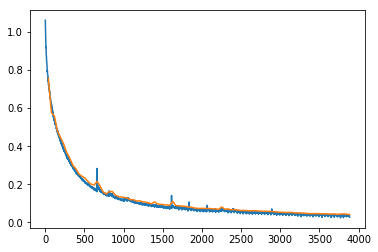

In [33]:
plt.plot(train_loss.keys(), train_loss.values())
plt.plot(val_loss.keys(), val_loss.values())

In [34]:
train_loss, val_loss = train(60, lr)

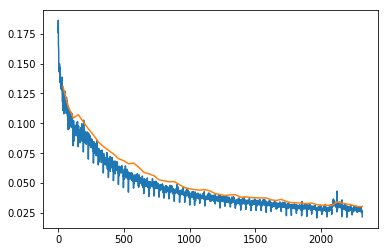

In [35]:
plt.plot(train_loss.keys(), train_loss.values())
plt.plot(val_loss.keys(), val_loss.values())

In [36]:
train_loss, val_loss = train(150, lr/10)

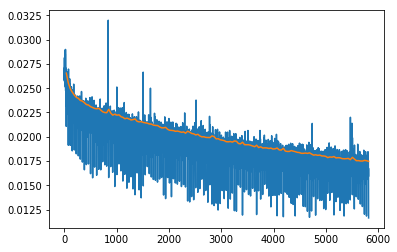

In [37]:
plt.plot(train_loss.keys(), train_loss.values())
plt.plot(val_loss.keys(), val_loss.values())

In [38]:
def get_batch(m):
    m.eval()
    X, y = next(iter(val_dl))
    
    X = X.cuda()
    p = m(X)
    
    X = denormalize(X)
    y = denormalize(y)
    p = denormalize(p)
    
    return [X, y, p]

In [39]:
def show_batch(batch, rows=5, cols=3, figsize=(40, 32)):
    figs, axes = plt.subplots(rows, cols, figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            axes[i][j].imshow(PIL.Image.fromarray(batch[j][i]))
    plt.tight_layout()

In [40]:
def get_seq_batch(m):
    m.eval()
    X, y = next(iter(val_dl))
    X = [X[i][0] for i in range(len(X))]
    
    p = m(X[0][None, None, :, :].cuda())
    ps = []
    
    for i in range(len(X)):
        ps.append(denormalize(p)[0])
        p = m(p[0][None, :, :])
        
    Y = [denormalize(y[i][0])[0] for i in range(7)]
    
    return [Y, ps]

In [41]:
imgs = get_batch(m)

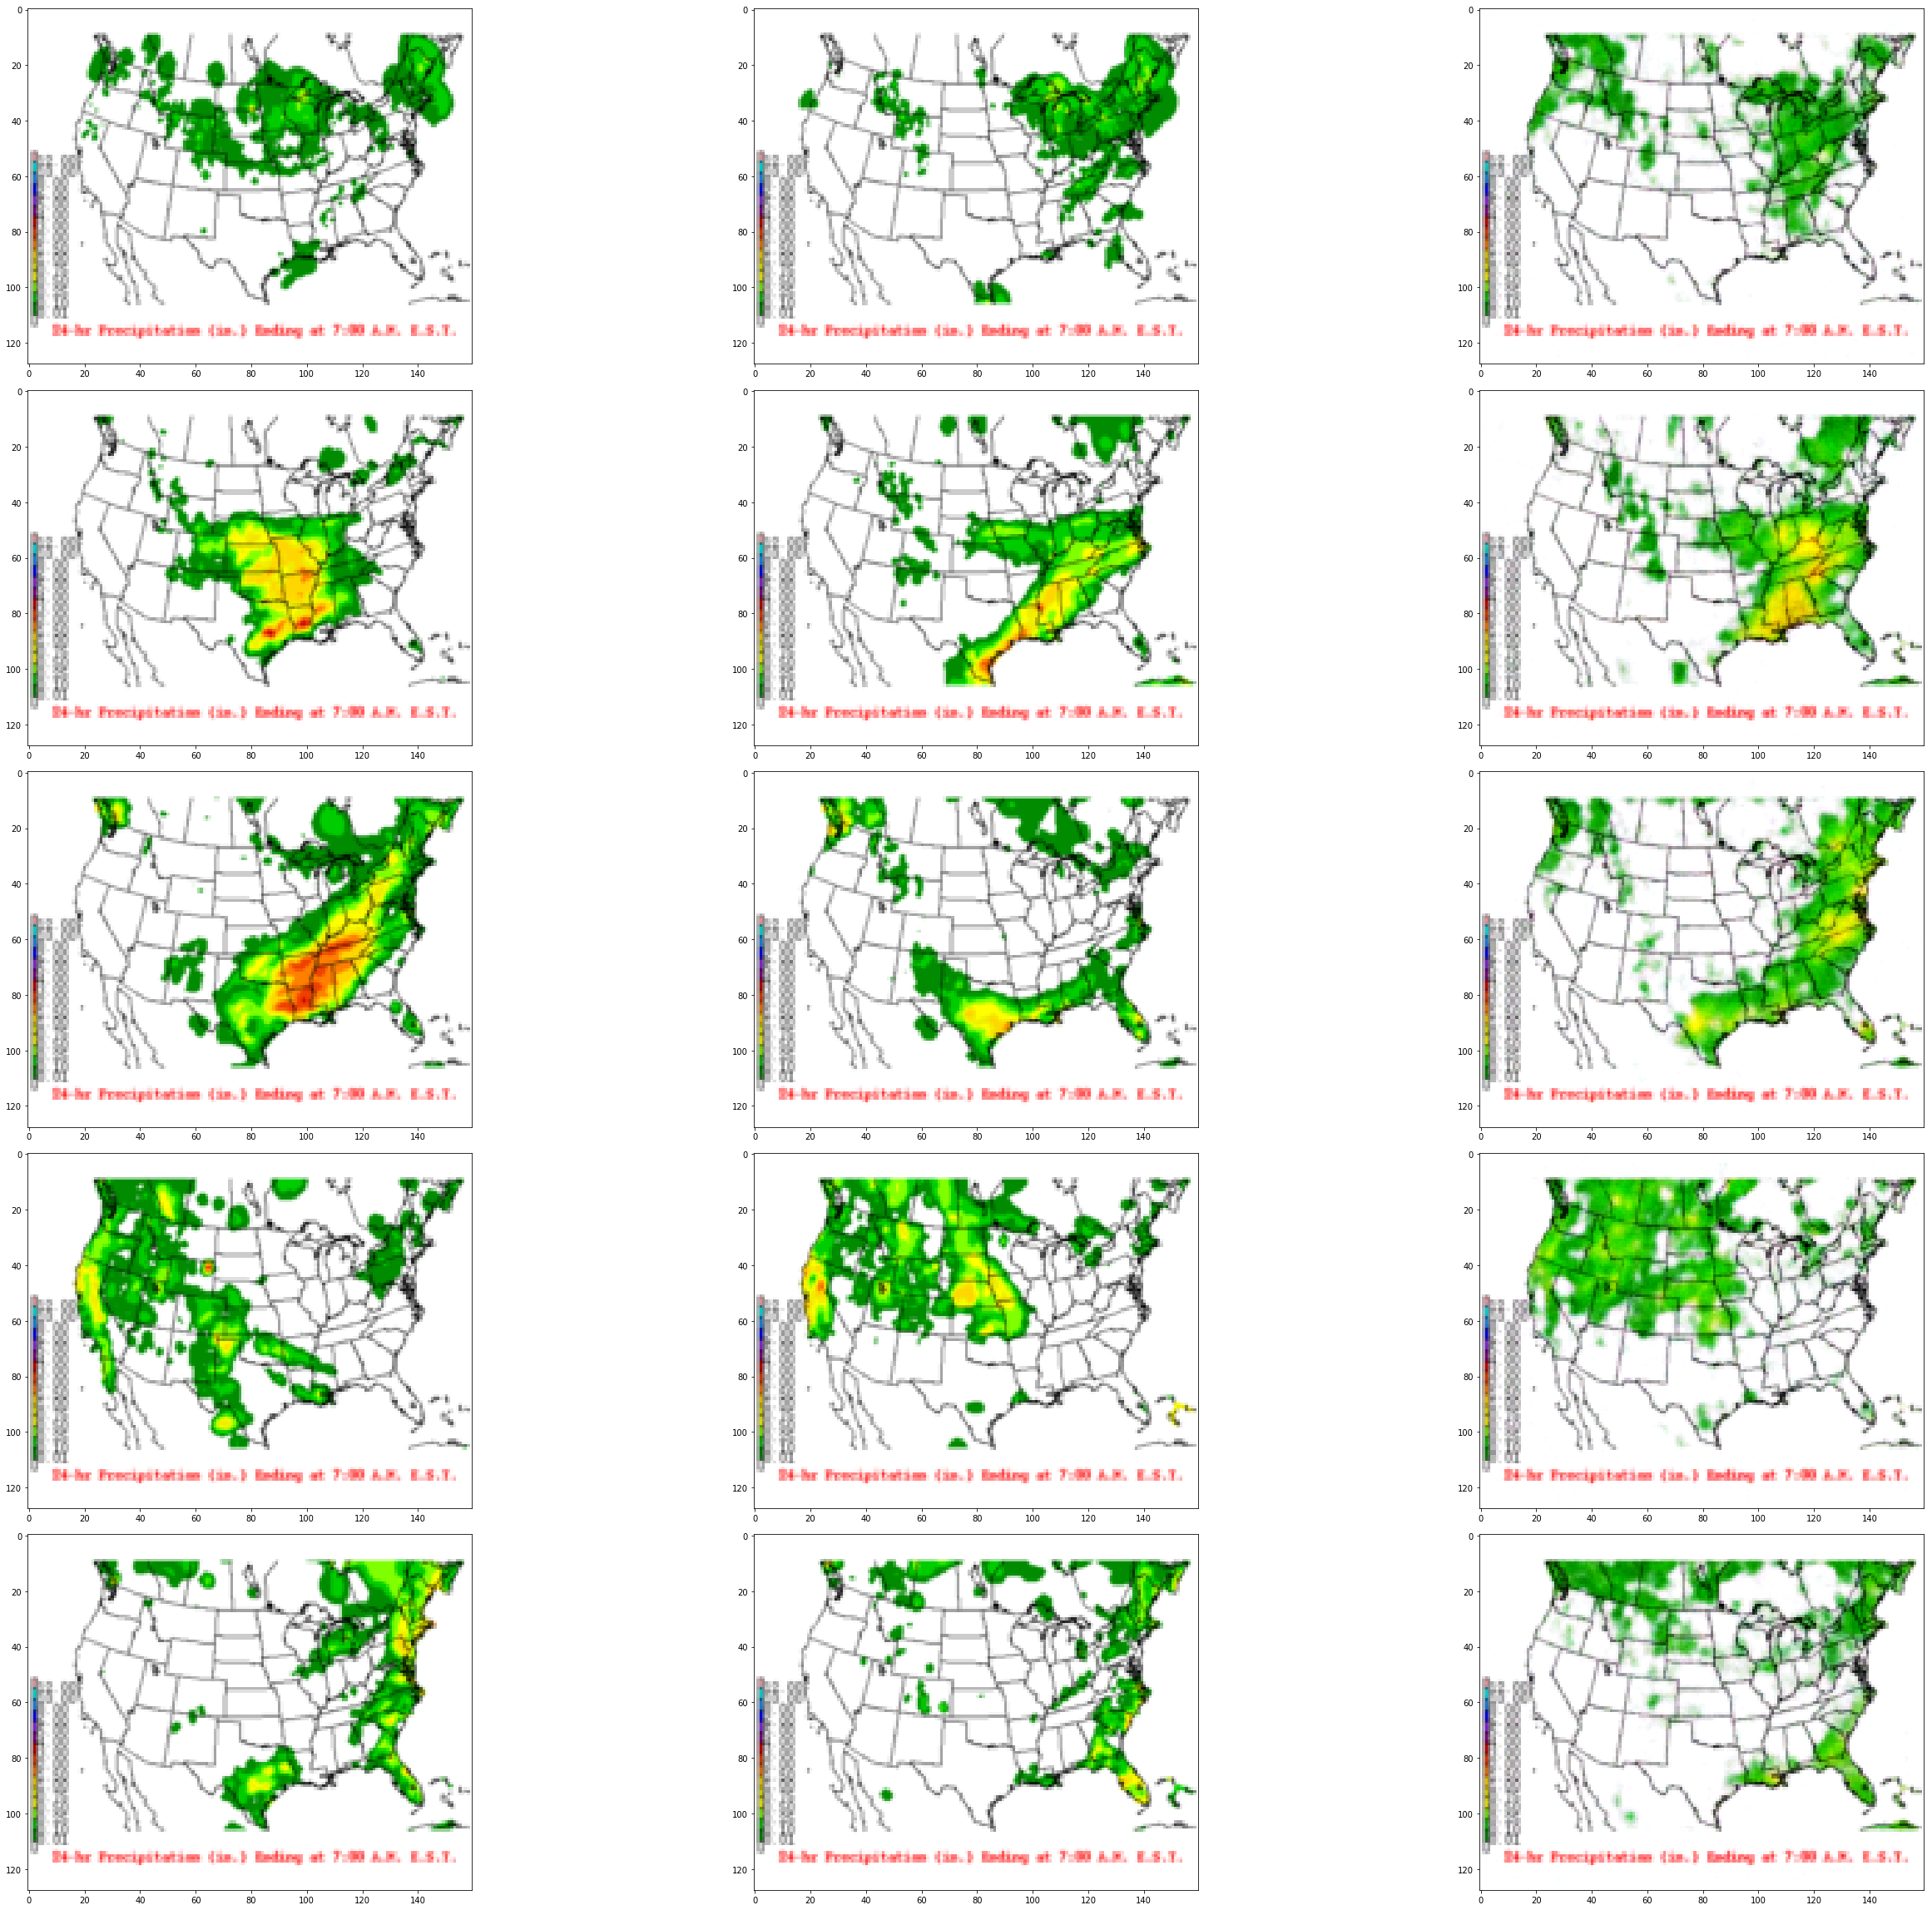

In [42]:
show_batch(imgs)

In [43]:
ps = get_seq_batch(m)

In [44]:
show_batch(ps, rows=7, cols=2, figsize=(320, 400))

In [45]:
%debug

In [46]:
# Red dragon: 0.017
# Pixel: 0.031

In [47]:
a = torch.rand(1, 4, 128, 160)

In [48]:
c = nn.Conv2d(4, 8, 3, padding=3//2+1, bias=False, padding_mode='circular')

In [49]:
c(a).shape

torch.Size([1, 8, 128, 160])